# Gesture ML Pro Experiments

This notebook trains and evaluates classical ML models for gesture classification from pose landmarks, with advanced feature engineering and cross-validation.

Outline:
- 1) Load & Explore Dataset
- 2) Feature Engineering
- 3) Preprocessing
- 4) Train/Test + Cross-Validation
- 5) Classical ML Models + Hyperparameter Tuning
- 6) Evaluation
- 7) Feature Importance
- 8) Save Best Model


In [1]:
# 1) Load & Explore Dataset
from pathlib import Path
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from typing import Dict, List, Tuple, Optional

# Display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)


notebook_dir = Path.cwd()
ml_dir = notebook_dir.parent
DATA_DIR = ml_dir / 'data' / 'gesture_raw'
print('Looking for CSVs in:', DATA_DIR)

# Load all CSV files
csv_paths = sorted(glob.glob(str(DATA_DIR / '*.csv')))
print('Found CSV files:', len(csv_paths))

if len(csv_paths) == 0:
    # Create an empty placeholder DataFrame if none found
    df = pd.DataFrame()
    print('WARNING: No CSV files found. Subsequent steps will be no-ops.')
else:
    dfs = []
    for p in csv_paths:
        try:
            dfi = pd.read_csv(p)
            dfi['__source_file'] = os.path.basename(p)
            dfs.append(dfi)
        except Exception as e:
            print(f'Failed to read {p}: {e}')
    df = pd.concat(dfs, ignore_index=True) if len(dfs) > 0 else pd.DataFrame()

print('Shape:', df.shape if isinstance(df, pd.DataFrame) else None)
if not df.empty:
    display(df.head(10))
    # Missing values summary
    missing_summary = df.isna().sum().sort_values(ascending=False)
    print('\nMissing values (top 20):')
    display(missing_summary.head(20))
    
    # Class distribution (expects a column named 'gesture')
    if 'gesture_label' in df.columns:
        print('\nClass distribution:')
        display(df['gesture_label'].value_counts().to_frame('count'))
    else:
        print("Column 'gesture' not found. Please ensure your CSVs include a 'gesture' column.")


Looking for CSVs in: C:\Users\Adhish\motion-edu-app\ml\data\gesture_raw
Found CSV files: 13
Shape: (3017, 139)


,session_id,frame_index,timestamp,gesture,gesture_label,landmark_0_x,landmark_0_y,landmark_0_z,landmark_0_visibility,landmark_1_x,landmark_1_y,landmark_1_z,landmark_1_visibility,landmark_2_x,landmark_2_y,landmark_2_z,landmark_2_visibility,landmark_3_x,landmark_3_y,landmark_3_z,landmark_3_visibility,landmark_4_x,landmark_4_y,landmark_4_z,landmark_4_visibility,landmark_5_x,landmark_5_y,landmark_5_z,landmark_5_visibility,landmark_6_x,landmark_6_y,landmark_6_z,landmark_6_visibility,landmark_7_x,landmark_7_y,landmark_7_z,landmark_7_visibility,landmark_8_x,landmark_8_y,landmark_8_z,landmark_8_visibility,landmark_9_x,landmark_9_y,landmark_9_z,landmark_9_visibility,landmark_10_x,landmark_10_y,landmark_10_z,landmark_10_visibility,landmark_11_x,landmark_11_y,landmark_11_z,landmark_11_visibility,landmark_12_x,landmark_12_y,landmark_12_z,landmark_12_visibility,landmark_13_x,landmark_13_y,landmark_13_z,landmark_13_visibility,landmark_14_x,landmark_14_y,landmark_14_z,landmark_14_visibility,landmark_15_x,landmark_15_y,landmark_15_z,landmark_15_visibility,landmark_16_x,landmark_16_y,landmark_16_z,landmark_16_visibility,landmark_17_x,landmark_17_y,landmark_17_z,landmark_17_visibility,landmark_18_x,landmark_18_y,landmark_18_z,landmark_18_visibility,landmark_19_x,landmark_19_y,landmark_19_z,landmark_19_visibility,landmark_20_x,landmark_20_y,landmark_20_z,landmark_20_visibility,landmark_21_x,landmark_21_y,landmark_21_z,landmark_21_visibility,landmark_22_x,landmark_22_y,landmark_22_z,landmark_22_visibility,landmark_23_x,landmark_23_y,landmark_23_z,landmark_23_visibility,landmark_24_x,landmark_24_y,landmark_24_z,landmark_24_visibility,landmark_25_x,landmark_25_y,landmark_25_z,landmark_25_visibility,landmark_26_x,landmark_26_y,landmark_26_z,landmark_26_visibility,landmark_27_x,landmark_27_y,landmark_27_z,landmark_27_visibility,landmark_28_x,landmark_28_y,landmark_28_z,landmark_28_visibility,landmark_29_x,landmark_29_y,landmark_29_z,landmark_29_visibility,landmark_30_x,landmark_30_y,landmark_30_z,landmark_30_visibility,landmark_31_x,landmark_31_y,landmark_31_z,landmark_31_visibility,landmark_32_x,landmark_32_y,landmark_32_z,landmark_32_visibility,__source_file,sample_index
0,20251122_131910,0.0,2025-11-22T13:19:13.977663,NEXT,NEXT,0.421014,0.029176,-0.970613,0.992938,0.435268,-0.018364,-0.901180,0.983131,0.447417,-0.015040,-0.901693,0.986281,0.459224,-0.010871,-0.901787,0.983670,0.399622,-0.023107,-0.911126,0.984970,0.386096,-0.022864,-0.911330,0.988785,0.371608,-0.021489,-0.911885,0.989017,0.470068,0.033417,-0.498797,0.980888,0.346288,0.024762,-0.607139,0.986671,0.436267,0.098517,-0.828634,0.993916,0.395057,0.093293,-0.845425,0.995751,0.585046,0.394230,-0.237501,0.982569,0.221810,0.435398,-0.431018,0.990043,0.817402,0.460043,-0.265602,0.363006,0.151636,0.929225,-0.458809,0.368499,1.029376,0.479132,-0.621800,0.148079,0.081732,1.264392,-0.828769,0.106231,1.111054,0.447355,-0.718777,0.161112,0.058276,1.382906,-0.923991,0.119628,1.090749,0.436845,-0.813626,0.200182,0.076908,1.364897,-1.044928,0.179646,1.058137,0.458256,-0.686540,0.188122,0.092084,1.322192,-0.892994,0.172187,0.529697,1.356221,0.006160,0.005687,0.296040,1.370219,-0.002926,0.007003,0.532256,2.064538,-0.154749,0.013316,0.307439,2.057289,-0.236407,0.005272,0.544871,2.753183,0.288415,0.000873,0.310377,2.766346,0.036934,0.000694,0.545013,2.860589,0.299585,0.000470,0.293161,2.879694,0.044348,0.000951,0.542776,2.933504,-0.197001,0.001489,0.384530,2.948587,-0.515741,0.002548,NEXT_session_20251122_131922.csv,NaN
1,20251122_131910,1.0,2025-11-22T13:19:14.008739,NEXT,NEXT,0.405343,0.035294,-1.060953,0.993482,0.420294,-0.012995,-0.984759,0.984169,0.432930,-0.011169,-0.985151,0.987056,0.445129,-0.008296,-0.985330,0.984693,0.383609,-0.014647,-1.015849,0.986047,0.370272,-0.014373,-1.015951,0.989545,0.356655,-0.013310,-1.016290,0.989706,0.456438,0.033716,-0.565746,0.982041,0.335918,0.029619,-0.710007,0.987536,0.424252,0.102207,-0.909132,0.994074,0.378845,0.097304,-0.947436,0.995804,0.577747,0.382206,-0.2


Missing values (top 20):


sample_index              3000
gesture                     17
frame_index                 17
session_id                  17
gesture_label                0
landmark_21_x                0
landmark_24_z                0
landmark_24_y                0
landmark_24_x                0
landmark_23_visibility       0
landmark_23_z                0
landmark_23_y                0
landmark_23_x                0
landmark_22_visibility       0
landmark_22_z                0
landmark_22_y                0
landmark_22_x                0
landmark_21_visibility       0
landmark_21_z                0
landmark_21_y                0
dtype: int64


Class distribution:


,count
gesture_label,
PREV,757
NEXT,755
SELECT,753
REST,752


## 2) Feature Engineering

We construct advanced features from pose landmark columns. This notebook expects columns like:
- landmark_{index}_{coord} (e.g., landmark_11_x, landmark_11_y), or similar

If your columns use a different naming, adjust the patterns below.

Toggles allow enabling/disabling feature families.


In [2]:
# Inspect columns and a few example rows for landmark names
if not df.empty:
    print('All columns (first 120):')
    print(list(df.columns)[:120])
    display(df.head(5))
else:
    print('No data loaded; skipping column inspection.')


All columns (first 120):
['session_id', 'frame_index', 'timestamp', 'gesture', 'gesture_label', 'landmark_0_x', 'landmark_0_y', 'landmark_0_z', 'landmark_0_visibility', 'landmark_1_x', 'landmark_1_y', 'landmark_1_z', 'landmark_1_visibility', 'landmark_2_x', 'landmark_2_y', 'landmark_2_z', 'landmark_2_visibility', 'landmark_3_x', 'landmark_3_y', 'landmark_3_z', 'landmark_3_visibility', 'landmark_4_x', 'landmark_4_y', 'landmark_4_z', 'landmark_4_visibility', 'landmark_5_x', 'landmark_5_y', 'landmark_5_z', 'landmark_5_visibility', 'landmark_6_x', 'landmark_6_y', 'landmark_6_z', 'landmark_6_visibility', 'landmark_7_x', 'landmark_7_y', 'landmark_7_z', 'landmark_7_visibility', 'landmark_8_x', 'landmark_8_y', 'landmark_8_z', 'landmark_8_visibility', 'landmark_9_x', 'landmark_9_y', 'landmark_9_z', 'landmark_9_visibility', 'landmark_10_x', 'landmark_10_y', 'landmark_10_z', 'landmark_10_visibility', 'landmark_11_x', 'landmark_11_y', 'landmark_11_z', 'landmark_11_visibility', 'landmark_12_x', 'la

,session_id,frame_index,timestamp,gesture,gesture_label,landmark_0_x,landmark_0_y,landmark_0_z,landmark_0_visibility,landmark_1_x,landmark_1_y,landmark_1_z,landmark_1_visibility,landmark_2_x,landmark_2_y,landmark_2_z,landmark_2_visibility,landmark_3_x,landmark_3_y,landmark_3_z,landmark_3_visibility,landmark_4_x,landmark_4_y,landmark_4_z,landmark_4_visibility,landmark_5_x,landmark_5_y,landmark_5_z,landmark_5_visibility,landmark_6_x,landmark_6_y,landmark_6_z,landmark_6_visibility,landmark_7_x,landmark_7_y,landmark_7_z,landmark_7_visibility,landmark_8_x,landmark_8_y,landmark_8_z,landmark_8_visibility,landmark_9_x,landmark_9_y,landmark_9_z,landmark_9_visibility,landmark_10_x,landmark_10_y,landmark_10_z,landmark_10_visibility,landmark_11_x,landmark_11_y,landmark_11_z,landmark_11_visibility,landmark_12_x,landmark_12_y,landmark_12_z,landmark_12_visibility,landmark_13_x,landmark_13_y,landmark_13_z,landmark_13_visibility,landmark_14_x,landmark_14_y,landmark_14_z,landmark_14_visibility,landmark_15_x,landmark_15_y,landmark_15_z,landmark_15_visibility,landmark_16_x,landmark_16_y,landmark_16_z,landmark_16_visibility,landmark_17_x,landmark_17_y,landmark_17_z,landmark_17_visibility,landmark_18_x,landmark_18_y,landmark_18_z,landmark_18_visibility,landmark_19_x,landmark_19_y,landmark_19_z,landmark_19_visibility,landmark_20_x,landmark_20_y,landmark_20_z,landmark_20_visibility,landmark_21_x,landmark_21_y,landmark_21_z,landmark_21_visibility,landmark_22_x,landmark_22_y,landmark_22_z,landmark_22_visibility,landmark_23_x,landmark_23_y,landmark_23_z,landmark_23_visibility,landmark_24_x,landmark_24_y,landmark_24_z,landmark_24_visibility,landmark_25_x,landmark_25_y,landmark_25_z,landmark_25_visibility,landmark_26_x,landmark_26_y,landmark_26_z,landmark_26_visibility,landmark_27_x,landmark_27_y,landmark_27_z,landmark_27_visibility,landmark_28_x,landmark_28_y,landmark_28_z,landmark_28_visibility,landmark_29_x,landmark_29_y,landmark_29_z,landmark_29_visibility,landmark_30_x,landmark_30_y,landmark_30_z,landmark_30_visibility,landmark_31_x,landmark_31_y,landmark_31_z,landmark_31_visibility,landmark_32_x,landmark_32_y,landmark_32_z,landmark_32_visibility,__source_file,sample_index
0,20251122_131910,0.0,2025-11-22T13:19:13.977663,NEXT,NEXT,0.421014,0.029176,-0.970613,0.992938,0.435268,-0.018364,-0.901180,0.983131,0.447417,-0.015040,-0.901693,0.986281,0.459224,-0.010871,-0.901787,0.983670,0.399622,-0.023107,-0.911126,0.984970,0.386096,-0.022864,-0.911330,0.988785,0.371608,-0.021489,-0.911885,0.989017,0.470068,0.033417,-0.498797,0.980888,0.346288,0.024762,-0.607139,0.986671,0.436267,0.098517,-0.828634,0.993916,0.395057,0.093293,-0.845425,0.995751,0.585046,0.394230,-0.237501,0.982569,0.221810,0.435398,-0.431018,0.990043,0.817402,0.460043,-0.265602,0.363006,0.151636,0.929225,-0.458809,0.368499,1.029376,0.479132,-0.621800,0.148079,0.081732,1.264392,-0.828769,0.106231,1.111054,0.447355,-0.718777,0.161112,0.058276,1.382906,-0.923991,0.119628,1.090749,0.436845,-0.813626,0.200182,0.076908,1.364897,-1.044928,0.179646,1.058137,0.458256,-0.686540,0.188122,0.092084,1.322192,-0.892994,0.172187,0.529697,1.356221,0.006160,0.005687,0.296040,1.370219,-0.002926,0.007003,0.532256,2.064538,-0.154749,0.013316,0.307439,2.057289,-0.236407,0.005272,0.544871,2.753183,0.288415,0.000873,0.310377,2.766346,0.036934,0.000694,0.545013,2.860589,0.299585,0.000470,0.293161,2.879694,0.044348,0.000951,0.542776,2.933504,-0.197001,0.001489,0.384530,2.948587,-0.515741,0.002548,NEXT_session_20251122_131922.csv,NaN
1,20251122_131910,1.0,2025-11-22T13:19:14.008739,NEXT,NEXT,0.405343,0.035294,-1.060953,0.993482,0.420294,-0.012995,-0.984759,0.984169,0.432930,-0.011169,-0.985151,0.987056,0.445129,-0.008296,-0.985330,0.984693,0.383609,-0.014647,-1.015849,0.986047,0.370272,-0.014373,-1.015951,0.989545,0.356655,-0.013310,-1.016290,0.989706,0.456438,0.033716,-0.565746,0.982041,0.335918,0.029619,-0.710007,0.987536,0.424252,0.102207,-0.909132,0.994074,0.378845,0.097304,-0.947436,0.995804,0.577747,0.382206,-0.2

In [3]:
# Create features_df as a working copy of df
features_df = df.copy()
print("features_df created with shape:", features_df.shape)


features_df created with shape: (3017, 139)


In [4]:
# Add elbow angles (degrees) and normalized wrist-shoulder distances to features_df
import numpy as np

if not df.empty and 'features_df' in globals():
    def safe_col(name):
        return name in df.columns

    def get_point(prefix):
        # Try semantic names first: e.g., right_shoulder_x/y
        x_col = f"{prefix}_x"
        y_col = f"{prefix}_y"
        if safe_col(x_col) and safe_col(y_col):
            return df[x_col], df[y_col]
        # Fallback: MediaPipe landmark indices mapping if present
        mp_index = {
            'left_shoulder': 11,
            'right_shoulder': 12,
            'left_elbow': 13,
            'right_elbow': 14,
            'left_wrist': 15,
            'right_wrist': 16,
            'left_hip': 23,
            'right_hip': 24,
        }.get(prefix, None)
        if mp_index is not None:
            lx = f"landmark_{mp_index}_x"
            ly = f"landmark_{mp_index}_y"
            if safe_col(lx) and safe_col(ly):
                return df[lx], df[ly]
        return None, None

    def compute_angle_deg(ax, ay, bx, by, cx, cy):
        v1x, v1y = ax - bx, ay - by
        v2x, v2y = cx - bx, cy - by
        dot = v1x * v2x + v1y * v2y
        n1 = np.sqrt(v1x**2 + v1y**2)
        n2 = np.sqrt(v2x**2 + v2y**2)
        denom = (n1 * n2) + 1e-9
        cosang = np.clip(dot / denom, -1.0, 1.0)
        return np.degrees(np.arccos(cosang))

    # Points
    rsx, rsy = get_point('right_shoulder')
    rex, rey = get_point('right_elbow')
    rwx, rwy = get_point('right_wrist')
    lsx, lsy = get_point('left_shoulder')
    lex, ley = get_point('left_elbow')
    lwx, lwy = get_point('left_wrist')
    rhx, rhy = get_point('right_hip')
    lhx, lhy = get_point('left_hip')

    # Compute elbow angles if points exist
    if all(s is not None for s in [rsx, rsy, rex, rey, rwx, rwy]):
        features_df['right_elbow_angle'] = compute_angle_deg(rsx, rsy, rex, rey, rwx, rwy)
    if all(s is not None for s in [lsx, lsy, lex, ley, lwx, lwy]):
        features_df['left_elbow_angle'] = compute_angle_deg(lsx, lsy, lex, ley, lwx, lwy)

    # Distances
    def euclid(ax, ay, bx, by):
        return np.sqrt((ax - bx)**2 + (ay - by)**2)

    if all(s is not None for s in [rwx, rwy, rsx, rsy]):
        features_df['dist_right_wrist_shoulder'] = euclid(rwx, rwy, rsx, rsy)
    if all(s is not None for s in [lwx, lwy, lsx, lsy]):
        features_df['dist_left_wrist_shoulder'] = euclid(lwx, lwy, lsx, lsy)

    # Reference size: try shoulder width; else hip width; else torso length (right_shoulder-right_hip)
    ref = None
    if all(s is not None for s in [rsx, rsy, lsx, lsy]):
        ref = euclid(rsx, rsy, lsx, lsy)
    elif all(s is not None for s in [rhx, rhy, lhx, lhy]):
        ref = euclid(rhx, rhy, lhx, lhy)
    elif all(s is not None for s in [rsx, rsy, rhx, rhy]):
        ref = euclid(rsx, rsy, rhx, rhy)

    if ref is not None:
        if 'dist_right_wrist_shoulder' in features_df:
            features_df['norm_dist_right_wrist_shoulder'] = features_df['dist_right_wrist_shoulder'] / (ref + 1e-9)
        if 'dist_left_wrist_shoulder' in features_df:
            features_df['norm_dist_left_wrist_shoulder'] = features_df['dist_left_wrist_shoulder'] / (ref + 1e-9)

    print('Added engineered columns now present:', [c for c in ['right_elbow_angle','left_elbow_angle','norm_dist_right_wrist_shoulder','norm_dist_left_wrist_shoulder'] if c in features_df.columns])
else:
    print('features_df not available or no data; skipping additional feature engineering.')


Added engineered columns now present: ['right_elbow_angle', 'left_elbow_angle', 'norm_dist_right_wrist_shoulder', 'norm_dist_left_wrist_shoulder']


In [5]:
# Helper utilities for feature extraction
import re
from typing import Dict, List, Tuple, Optional

# Landmark indices (MediaPipe Pose)
LEFT_SHOULDER = 11
RIGHT_SHOULDER = 12
LEFT_ELBOW = 13
RIGHT_ELBOW = 14
LEFT_WRIST = 15
RIGHT_WRIST = 16
LEFT_HIP = 23
RIGHT_HIP = 24

# Feature toggles
USE_NORMALIZED = True
USE_ANGLES = True
USE_DISTANCES = True
USE_DX_DY = True
USE_VELOCITIES = True  # requires timestamp column (or frame index)

# Column name patterns
# Expected: landmark_{idx}_{coord} (coord in {'x','y','z','visibility'})
LANDMARK_PATTERN = re.compile(r"landmark_(\d+)_(x|y|z|visibility)")


def detect_landmark_columns(columns: List[str]) -> Dict[int, Dict[str, str]]:
    """Return mapping: index -> {coord: column_name} for columns matching the pattern."""
    mapping: Dict[int, Dict[str, str]] = {}
    for col in columns:
        m = LANDMARK_PATTERN.match(col)
        if m:
            idx = int(m.group(1))
            coord = m.group(2)
            mapping.setdefault(idx, {})[coord] = col
    return mapping


def angle_three_points(ax, ay, bx, by, cx, cy):
    """
    Compute the angle ABC (in radians) for each row, where:
      A(ax, ay), B(bx, by), C(cx, cy)
    Supports pandas Series (vectorized).
    """
    # Vectors BA and BC
    v1x, v1y = ax - bx, ay - by
    v2x, v2y = cx - bx, cy - by

    # Dot product and norms
    dot = v1x * v2x + v1y * v2y
    n1 = (v1x**2 + v1y**2) ** 0.5
    n2 = (v2x**2 + v2y**2) ** 0.5

    denom = n1 * n2

    # Avoid division by zero: where denom is 0, set cosang to NaN
    cosang = dot / denom
    if isinstance(cosang, pd.Series):
        cosang = cosang.where(denom != 0, np.nan)
    else:
        # fallback in case of numpy arrays
        cosang = np.where(denom != 0, cosang, np.nan)

    # Clip to [-1, 1] before arccos
    cosang_clipped = np.clip(cosang, -1.0, 1.0)

    angles = np.arccos(cosang_clipped)

    # Ensure we return a pandas Series if inputs were Series
    if isinstance(ax, pd.Series):
        return pd.Series(angles, index=ax.index)
    return angles


def build_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str]]:
    """
    Build engineered features from available landmark columns.
    Returns (features_df, label_columns_removed)
    """
    if df.empty:
        return df.copy(), []

    mapping = detect_landmark_columns(df.columns.tolist())
    features = pd.DataFrame(index=df.index)

    # Optionally normalize coordinates per-frame to [0,1] based on min/max among all available x,y
    if USE_NORMALIZED:
        x_cols = [mapping[i]['x'] for i in mapping if 'x' in mapping[i]]
        y_cols = [mapping[i]['y'] for i in mapping if 'y' in mapping[i]]
        if x_cols and y_cols:
            x_min = df[x_cols].min(axis=1)
            x_max = df[x_cols].max(axis=1)
            y_min = df[y_cols].min(axis=1)
            y_max = df[y_cols].max(axis=1)
            for i in mapping:
                if 'x' in mapping[i]:
                    features[f'norm_x_{i}'] = (df[mapping[i]['x']] - x_min) / (x_max - x_min + 1e-9)
                if 'y' in mapping[i]:
                    features[f'norm_y_{i}'] = (df[mapping[i]['y']] - y_min) / (y_max - y_min + 1e-9)
        else:
            # Fallback to raw coordinates
            for i in mapping:
                if 'x' in mapping[i]:
                    features[f'x_{i}'] = df[mapping[i]['x']]
                if 'y' in mapping[i]:
                    features[f'y_{i}'] = df[mapping[i]['y']]
    else:
        for i in mapping:
            if 'x' in mapping[i]:
                features[f'x_{i}'] = df[mapping[i]['x']]
            if 'y' in mapping[i]:
                features[f'y_{i}'] = df[mapping[i]['y']]

    # Utility to read normalized (preferred) or raw coordinate from features
    def coord(i: int, axis: str):
        if f'norm_{axis}_{i}' in features:
            return features[f'norm_{axis}_{i}']
        return features.get(f'{axis}_{i}', pd.Series(np.nan, index=features.index))

    # Joint angles (shoulder-elbow-wrist), if available
    if USE_ANGLES and all(k in mapping for k in [LEFT_SHOULDER, LEFT_ELBOW, LEFT_WRIST, RIGHT_SHOULDER, RIGHT_ELBOW, RIGHT_WRIST]):
        # Left arm angle
        la = angle_three_points(
            coord(LEFT_SHOULDER, 'x'), coord(LEFT_SHOULDER, 'y'),
            coord(LEFT_ELBOW, 'x'), coord(LEFT_ELBOW, 'y'),
            coord(LEFT_WRIST, 'x'), coord(LEFT_WRIST, 'y')
        )
        # Right arm angle
        ra = angle_three_points(
            coord(RIGHT_SHOULDER, 'x'), coord(RIGHT_SHOULDER, 'y'),
            coord(RIGHT_ELBOW, 'x'), coord(RIGHT_ELBOW, 'y'),
            coord(RIGHT_WRIST, 'x'), coord(RIGHT_WRIST, 'y')
        )
        # angle_three_points supports array inputs via pandas and numpy broadcasting
        features['angle_left_arm_rad'] = la
        features['angle_right_arm_rad'] = ra

    # Distances (Euclidean)
    def dist(i: int, j: int) -> pd.Series:
        dx = coord(i, 'x') - coord(j, 'x')
        dy = coord(i, 'y') - coord(j, 'y')
        return np.sqrt(dx**2 + dy**2)

    if USE_DISTANCES:
        # wrist-shoulder (left/right)
        if all(k in mapping for k in [LEFT_WRIST, LEFT_SHOULDER]):
            features['dist_left_wrist_shoulder'] = dist(LEFT_WRIST, LEFT_SHOULDER)
        if all(k in mapping for k in [RIGHT_WRIST, RIGHT_SHOULDER]):
            features['dist_right_wrist_shoulder'] = dist(RIGHT_WRIST, RIGHT_SHOULDER)
        # wrist-hip (left/right)
        if all(k in mapping for k in [LEFT_WRIST, LEFT_HIP]):
            features['dist_left_wrist_hip'] = dist(LEFT_WRIST, LEFT_HIP)
        if all(k in mapping for k in [RIGHT_WRIST, RIGHT_HIP]):
            features['dist_right_wrist_hip'] = dist(RIGHT_WRIST, RIGHT_HIP)
        # shoulder-hip (left/right)
        if all(k in mapping for k in [LEFT_SHOULDER, LEFT_HIP]):
            features['dist_left_shoulder_hip'] = dist(LEFT_SHOULDER, LEFT_HIP)
        if all(k in mapping for k in [RIGHT_SHOULDER, RIGHT_HIP]):
            features['dist_right_shoulder_hip'] = dist(RIGHT_SHOULDER, RIGHT_HIP)

    # dx, dy relative to shoulder baselines
    if USE_DX_DY:
        if all(k in mapping for k in [RIGHT_WRIST, RIGHT_SHOULDER]):
            features['dx_right_wrist_shoulder'] = coord(RIGHT_WRIST, 'x') - coord(RIGHT_SHOULDER, 'x')
            features['dy_right_wrist_shoulder'] = coord(RIGHT_WRIST, 'y') - coord(RIGHT_SHOULDER, 'y')
        if all(k in mapping for k in [LEFT_WRIST, LEFT_SHOULDER]):
            features['dx_left_wrist_shoulder'] = coord(LEFT_WRIST, 'x') - coord(LEFT_SHOULDER, 'x')
            features['dy_left_wrist_shoulder'] = coord(LEFT_WRIST, 'y') - coord(LEFT_SHOULDER, 'y')

    # Velocities if a 'timestamp' or 'frame' column exists (assume milliseconds for timestamp)
    if USE_VELOCITIES:
        time_col = None
        for c in ['timestamp', 'time_ms', 'frame', 't']:
            if c in df.columns:
                time_col = c
                break
        if time_col is not None:
            # Use numeric progression
            t = pd.to_numeric(df[time_col], errors='coerce').fillna(method='ffill').fillna(method='bfill')
            for name, i in [('left_wrist', LEFT_WRIST), ('right_wrist', RIGHT_WRIST)]:
                vx = coord(i, 'x').diff() / (t.diff() + 1e-9)
                vy = coord(i, 'y').diff() / (t.diff() + 1e-9)
                features[f'vel_{name}_x'] = vx.fillna(0.0)
                features[f'vel_{name}_y'] = vy.fillna(0.0)

    # Attach labels if present
    labels = []
    if 'gesture' in df.columns:
        features['gesture'] = df['gesture']
        labels.append('gesture')

    print('Engineered features shape:', features.shape)
    display(features.head(10))
    return features, labels


features_df, label_cols = build_features(df)


Engineered features shape: (3017, 83)


C:\Users\Adhish\AppData\Local\Temp\ipykernel_19012\3879541471.py:179: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  t = pd.to_numeric(df[time_col], errors='coerce').fillna(method='ffill').fillna(method='bfill')


,norm_x_0,norm_y_0,norm_x_1,norm_y_1,norm_x_2,norm_y_2,norm_x_3,norm_y_3,norm_x_4,norm_y_4,norm_x_5,norm_y_5,norm_x_6,norm_y_6,norm_x_7,norm_y_7,norm_x_8,norm_y_8,norm_x_9,norm_y_9,norm_x_10,norm_y_10,norm_x_11,norm_y_11,norm_x_12,norm_y_12,norm_x_13,norm_y_13,norm_x_14,norm_y_14,norm_x_15,norm_y_15,norm_x_16,norm_y_16,norm_x_17,norm_y_17,norm_x_18,norm_y_18,norm_x_19,norm_y_19,norm_x_20,norm_y_20,norm_x_21,norm_y_21,norm_x_22,norm_y_22,norm_x_23,norm_y_23,norm_x_24,norm_y_24,norm_x_25,norm_y_25,norm_x_26,norm_y_26,norm_x_27,norm_y_27,norm_x_28,norm_y_28,norm_x_29,norm_y_29,norm_x_30,norm_y_30,norm_x_31,norm_y_31,norm_x_32,norm_y_32,angle_left_arm_rad,angle_right_arm_rad,dist_left_wrist_shoulder,dist_right_wrist_shoulder,dist_left_wrist_hip,dist_right_wrist_hip,dist_left_shoulder_hip,dist_right_shoulder_hip,dx_right_wrist_shoulder,dy_right_wrist_shoulder,dx_left_wrist_shoulder,dy_left_wrist_shoulder,vel_left_wrist_x,vel_left_wrist_y,vel_right_wrist_x,vel_right_wrist_y,gesture
0,0.344554,0.017594,0.358093,0.001596,0.369633,0.002715,0.380848,0.004118,0.324234,0.000000,0.311386,0.000082,0.297625,0.000545,0.391148,0.019021,0.273574,0.016109,0.359041,0.040928,0.319898,0.039170,0.500362,0.140437,0.155336,0.154291,0.721069,0.162584,0.088680,0.320468,0.922417,0.169008,0.022281,0.433254,1.0,0.158314,0.0,0.473135,0.980713,0.154778,0.017699,0.467075,0.949736,0.161983,0.032114,0.452704,0.447788,0.464156,0.225845,0.468866,0.450219,0.702510,0.236672,0.700071,0.462201,0.934245,0.239463,0.938674,0.462336,0.970388,0.223110,0.976817,0.460211,0.994924,0.309898,1.0,3.073475,2.990977,0.423020,0.309070,0.558914,0.206656,0.327960,0.322380,-0.133055,0.278963,0.422054,0.028570,0.0,0.0,0.0,0.0,NEXT
1,0.315862,0.017342,0.329975,0.000573,0.341904,0.001208,0.353420,0.002206,0.295345,0.000000,0.282755,0.000095,0.269901,0.000464,0.364095,0.016794,0.250325,0.015371,0.333712,0.040578,0.290848,0.038875,0.478610,0.137808,0.138681,0.156408,0.719760,0.146809,0.073547,0.317806,0.926306,0.164418,0.020964,0.443892,1.0,0.164130,0.0,0.485284,0.982657,0.163533,0.016838,0.479978,0.953935,0.170021,0.029954,0.465524,0.415859,0.462474,0.206656,0.466364,0.418505,0.690579,0.214442,0.688007,0.430326,0.927155,0.211519,0.938291,0.428437,0.963562,0.190414,0.978221,0.438596,0.986283,0.289990,1.0,3.093855,3.130059,0.448486,0.310651,0.591095,0.187047,0.330675,0.317322,-0.117718,0.287484,0.447696,0.026610,0.0,0.0,0.0,0.0,NEXT
2,0.328632,0.018780,0.345673,0.000418,0.359579,0.000904,0.372299,0.001753,0.305775,0.000000,0.292689,0.000076,0.280149,0.000419,0.384686,0.016025,0.262534,0.015009,0.351101,0.041875,0.301330,0.040276,0.504637,0.133822,0.145384,0.155002,0.744741,0.143014,0.075019,0.310779,0.930314,0.139159,0.021813,0.438077,1.0,0.135115,0.0,0.480106,0.976056,0.132112,0.018089,0.475480,0.948218,0.138852,0.032110,0.461379,0.438580,0.460410,0.217205,0.463626,0.425759,0.689933,0.217726,0.686012,0.442041,0.927215,0.211521,0.937019,0.442631,0.964497,0.193041,0.976791,0.445101,0.987597,0.284990,1.0,3.082559,3.113213,0.425711,0.308871,0.587371,0.197055,0.333201,0.316870,-0.123571,0.283075,0.425677,0.005337,0.0,0.0,0.0,0.0,NEXT
3,0.316833,0.017626,0.331266,0.000073,0.343847,0.000549,0.355978,0.001408,0.295555,0.000000,0.283321,0.000236,0.271632,0.000719,0.365563,0.015430,0.254013,0.015259,0.336413,0.040855,0.290611,0.039266,0.489740,0.128246,0.133270,0.154250,0.737138,0.141157,0.055405,0.307708,0.925813,0.145049,0.007729,0.421535,1.0,0.143970,0.0,0.462595,0.976567,0.141195,0.018770,0.455795,0.947608,0.147264,0.024610,0.442015,0.430539,0.448965,0.204563,0.455001,0.424756,0.689125,0.205877,0.688935,0.444258,0.927843,0.208189,0.938946,0.445046,0.965326,0.192157,0.977797,0.443303,0.986269,0.277360,1.0,3.110079,3.068685,0.436396,0.295300,0.581086,0.199659,0.326136,0.309085,-0.125542,0.267285,0.436073,0.016803,0.0,0.0,0.0,0.0,NEXT
4,0.283512,0.017897,0.296464,0.000000,0.308198,0.000456,0.319515,0.001291,0.263432,0.000114,0.251999,0.000474,0.241216,0.001050,0.329503,0.015141,0.223572,0.015228,0

In [6]:
print("df shape:", df.shape)
print("df columns:", df.columns.tolist())
df.head()

df shape: (3017, 139)
df columns: ['session_id', 'frame_index', 'timestamp', 'gesture', 'gesture_label', 'landmark_0_x', 'landmark_0_y', 'landmark_0_z', 'landmark_0_visibility', 'landmark_1_x', 'landmark_1_y', 'landmark_1_z', 'landmark_1_visibility', 'landmark_2_x', 'landmark_2_y', 'landmark_2_z', 'landmark_2_visibility', 'landmark_3_x', 'landmark_3_y', 'landmark_3_z', 'landmark_3_visibility', 'landmark_4_x', 'landmark_4_y', 'landmark_4_z', 'landmark_4_visibility', 'landmark_5_x', 'landmark_5_y', 'landmark_5_z', 'landmark_5_visibility', 'landmark_6_x', 'landmark_6_y', 'landmark_6_z', 'landmark_6_visibility', 'landmark_7_x', 'landmark_7_y', 'landmark_7_z', 'landmark_7_visibility', 'landmark_8_x', 'landmark_8_y', 'landmark_8_z', 'landmark_8_visibility', 'landmark_9_x', 'landmark_9_y', 'landmark_9_z', 'landmark_9_visibility', 'landmark_10_x', 'landmark_10_y', 'landmark_10_z', 'landmark_10_visibility', 'landmark_11_x', 'landmark_11_y', 'landmark_11_z', 'landmark_11_visibility', 'landmark_1

,session_id,frame_index,timestamp,gesture,gesture_label,landmark_0_x,landmark_0_y,landmark_0_z,landmark_0_visibility,landmark_1_x,landmark_1_y,landmark_1_z,landmark_1_visibility,landmark_2_x,landmark_2_y,landmark_2_z,landmark_2_visibility,landmark_3_x,landmark_3_y,landmark_3_z,landmark_3_visibility,landmark_4_x,landmark_4_y,landmark_4_z,landmark_4_visibility,landmark_5_x,landmark_5_y,landmark_5_z,landmark_5_visibility,landmark_6_x,landmark_6_y,landmark_6_z,landmark_6_visibility,landmark_7_x,landmark_7_y,landmark_7_z,landmark_7_visibility,landmark_8_x,landmark_8_y,landmark_8_z,landmark_8_visibility,landmark_9_x,landmark_9_y,landmark_9_z,landmark_9_visibility,landmark_10_x,landmark_10_y,landmark_10_z,landmark_10_visibility,landmark_11_x,landmark_11_y,landmark_11_z,landmark_11_visibility,landmark_12_x,landmark_12_y,landmark_12_z,landmark_12_visibility,landmark_13_x,landmark_13_y,landmark_13_z,landmark_13_visibility,landmark_14_x,landmark_14_y,landmark_14_z,landmark_14_visibility,landmark_15_x,landmark_15_y,landmark_15_z,landmark_15_visibility,landmark_16_x,landmark_16_y,landmark_16_z,landmark_16_visibility,landmark_17_x,landmark_17_y,landmark_17_z,landmark_17_visibility,landmark_18_x,landmark_18_y,landmark_18_z,landmark_18_visibility,landmark_19_x,landmark_19_y,landmark_19_z,landmark_19_visibility,landmark_20_x,landmark_20_y,landmark_20_z,landmark_20_visibility,landmark_21_x,landmark_21_y,landmark_21_z,landmark_21_visibility,landmark_22_x,landmark_22_y,landmark_22_z,landmark_22_visibility,landmark_23_x,landmark_23_y,landmark_23_z,landmark_23_visibility,landmark_24_x,landmark_24_y,landmark_24_z,landmark_24_visibility,landmark_25_x,landmark_25_y,landmark_25_z,landmark_25_visibility,landmark_26_x,landmark_26_y,landmark_26_z,landmark_26_visibility,landmark_27_x,landmark_27_y,landmark_27_z,landmark_27_visibility,landmark_28_x,landmark_28_y,landmark_28_z,landmark_28_visibility,landmark_29_x,landmark_29_y,landmark_29_z,landmark_29_visibility,landmark_30_x,landmark_30_y,landmark_30_z,landmark_30_visibility,landmark_31_x,landmark_31_y,landmark_31_z,landmark_31_visibility,landmark_32_x,landmark_32_y,landmark_32_z,landmark_32_visibility,__source_file,sample_index
0,20251122_131910,0.0,2025-11-22T13:19:13.977663,NEXT,NEXT,0.421014,0.029176,-0.970613,0.992938,0.435268,-0.018364,-0.901180,0.983131,0.447417,-0.015040,-0.901693,0.986281,0.459224,-0.010871,-0.901787,0.983670,0.399622,-0.023107,-0.911126,0.984970,0.386096,-0.022864,-0.911330,0.988785,0.371608,-0.021489,-0.911885,0.989017,0.470068,0.033417,-0.498797,0.980888,0.346288,0.024762,-0.607139,0.986671,0.436267,0.098517,-0.828634,0.993916,0.395057,0.093293,-0.845425,0.995751,0.585046,0.394230,-0.237501,0.982569,0.221810,0.435398,-0.431018,0.990043,0.817402,0.460043,-0.265602,0.363006,0.151636,0.929225,-0.458809,0.368499,1.029376,0.479132,-0.621800,0.148079,0.081732,1.264392,-0.828769,0.106231,1.111054,0.447355,-0.718777,0.161112,0.058276,1.382906,-0.923991,0.119628,1.090749,0.436845,-0.813626,0.200182,0.076908,1.364897,-1.044928,0.179646,1.058137,0.458256,-0.686540,0.188122,0.092084,1.322192,-0.892994,0.172187,0.529697,1.356221,0.006160,0.005687,0.296040,1.370219,-0.002926,0.007003,0.532256,2.064538,-0.154749,0.013316,0.307439,2.057289,-0.236407,0.005272,0.544871,2.753183,0.288415,0.000873,0.310377,2.766346,0.036934,0.000694,0.545013,2.860589,0.299585,0.000470,0.293161,2.879694,0.044348,0.000951,0.542776,2.933504,-0.197001,0.001489,0.384530,2.948587,-0.515741,0.002548,NEXT_session_20251122_131922.csv,NaN
1,20251122_131910,1.0,2025-11-22T13:19:14.008739,NEXT,NEXT,0.405343,0.035294,-1.060953,0.993482,0.420294,-0.012995,-0.984759,0.984169,0.432930,-0.011169,-0.985151,0.987056,0.445129,-0.008296,-0.985330,0.984693,0.383609,-0.014647,-1.015849,0.986047,0.370272,-0.014373,-1.015951,0.989545,0.356655,-0.013310,-1.016290,0.989706,0.456438,0.033716,-0.565746,0.982041,0.335918,0.029619,-0.710007,0.987536,0.424252,0.102207,-0.909132,0.994074,0.378845,0.097304,-0.947436,0.995804,0.577747,0.382206,-0.2

## 3) Preprocessing

- Drop NaNs
- Separate X and y
- Encode y using LabelEncoder
- Scale features using StandardScaler (fit on train only)


In [7]:
# 3) Preprocessing Code
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1) Detect the label column name
possible_label_cols = ["gesture", "label", "gesture_label", "class"]
label_col = None
for c in possible_label_cols:
    if c in df.columns:
        label_col = c
        break

if label_col is None:
    raise ValueError(
        f"No label column found. Looked for {possible_label_cols} in df.columns={df.columns.tolist()}"
    )

# 2) Standardize the label name to 'gesture' in BOTH df and features_df
#    so we don't have to care what it was originally called
if label_col != "gesture":
    df = df.rename(columns={label_col: "gesture"})
    label_col = "gesture"

# Make sure features_df exists as a copy of df
if "features_df" not in globals():
    features_df = df.copy()
else:
    features_df = features_df.copy()

# Ensure 'gesture' column is present in features_df
if "gesture" not in features_df.columns:
    features_df["gesture"] = df.loc[features_df.index, "gesture"]

# 3) Drop rows with NaNs
work = features_df.copy()
work = work.dropna(axis=0)

# 4) Separate features and labels
if "gesture" not in work.columns:
    raise ValueError("Column 'gesture' missing after feature engineering.")

y = work["gesture"].astype(str)
X = work.drop(columns=["gesture"])
feature_names = X.columns.tolist()

# 5) Encode labels
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

# 6) Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 7) Scale features using StandardScaler (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Classes:", label_encoder.classes_)


Train shape: (2400, 82)
Test shape: (600, 82)
Classes: ['NEXT' 'PREV' 'REST' 'SELECT']


## 4) Train/Test + Cross-Validation

- Train/test split already created
- Create StratifiedKFold for cross-validation (n_splits=5)


In [8]:
# Define CV splitter
if df.empty:
    cv = None
    print('No data loaded. Skipping CV setup.')
else:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print(cv)


StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


## 5) Classical ML Models + Hyperparameter Tuning

We will try and tune:
- RandomForestClassifier
- LogisticRegression
- GradientBoostingClassifier
- (Optional) SVM

We will use GridSearchCV (small grids) with the StratifiedKFold splitter. Each model’s best params and cross-validation accuracy will be shown.


In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

model_results = []
best_estimators = {}

if df.empty:
    print('No data loaded. Skipping model training.')
else:
    # Random Forest grid
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
    }
    rf_cv = GridSearchCV(rf, rf_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0)
    rf_cv.fit(X_train_scaled, y_train)
    print('RF best params:', rf_cv.best_params_)
    print('RF best CV accuracy:', rf_cv.best_score_)
    model_results.append(('RandomForest', rf_cv.best_score_))
    best_estimators['RandomForest'] = rf_cv.best_estimator_

    # Logistic Regression grid (liblinear/saga for multinomial)
    lr = LogisticRegression(max_iter=2000, n_jobs=None, solver='lbfgs', multi_class='auto')
    lr_grid = {
        'C': [0.1, 1.0, 3.0],
        'penalty': ['l2']
    }
    lr_cv = GridSearchCV(lr, lr_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0)
    lr_cv.fit(X_train_scaled, y_train)
    print('LR best params:', lr_cv.best_params_)
    print('LR best CV accuracy:', lr_cv.best_score_)
    model_results.append(('LogisticRegression', lr_cv.best_score_))
    best_estimators['LogisticRegression'] = lr_cv.best_estimator_

    # Gradient Boosting grid
    gb = GradientBoostingClassifier(random_state=42)
    gb_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [2, 3]
    }
    gb_cv = GridSearchCV(gb, gb_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0)
    gb_cv.fit(X_train, y_train)  # Note: tree-based models can work on unscaled features
    print('GB best params:', gb_cv.best_params_)
    print('GB best CV accuracy:', gb_cv.best_score_)
    model_results.append(('GradientBoosting', gb_cv.best_score_))
    best_estimators['GradientBoosting'] = gb_cv.best_estimator_

    # Optional SVM (smaller grid due to cost)
    try:
        svm = SVC(kernel='rbf', probability=False, random_state=42)
        svm_grid = {
            'C': [0.5, 1, 3],
            'gamma': ['scale', 0.1, 0.01],
        }
        svm_cv = GridSearchCV(svm, svm_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0)
        svm_cv.fit(X_train_scaled, y_train)
        print('SVM best params:', svm_cv.best_params_)
        print('SVM best CV accuracy:', svm_cv.best_score_)
        model_results.append(('SVM', svm_cv.best_score_))
        best_estimators['SVM'] = svm_cv.best_estimator_
    except Exception as e:
        print('SVM training skipped due to error:', e)

    # Pick best by CV
    model_results.sort(key=lambda t: t[1], reverse=True)
    print('\nModel CV leaderboard:')
    for name, score in model_results:
        print(f'{name}: {score:.4f}')
    best_model_name = model_results[0][0]
    best_model = best_estimators[best_model_name]
    print('\nBest model selected:', best_model_name)


RF best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
RF best CV accuracy: 0.99875
LR best params: {'C': 0.1, 'penalty': 'l2'}
LR best CV accuracy: 0.99875


C:\Users\Adhish\motion-edu-app\ml\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


GB best params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
GB best CV accuracy: 0.99875
SVM best params: {'C': 0.5, 'gamma': 'scale'}
SVM best CV accuracy: 0.99875

Model CV leaderboard:
RandomForest: 0.9988
LogisticRegression: 0.9988
GradientBoosting: 0.9988
SVM: 0.9988

Best model selected: RandomForest


## 6) Evaluation

On the test set, compute:
- Accuracy
- Precision/Recall/F1 (macro)
- Confusion matrix and heatmap
- Per-class F1 bar chart


Test accuracy: 1.0

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150
           2       1.00      1.00      1.00       150
           3       1.00      1.00      1.00       150

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



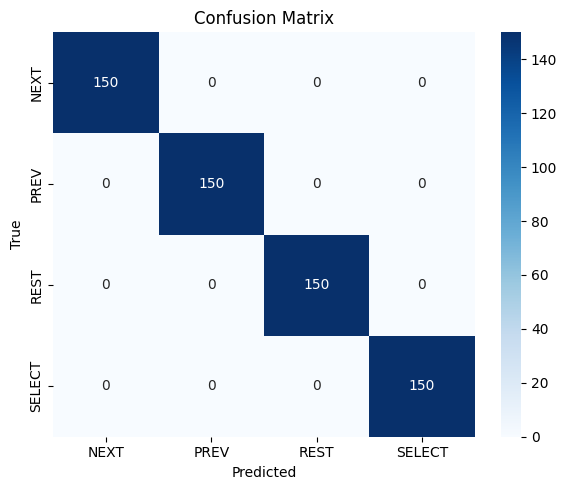

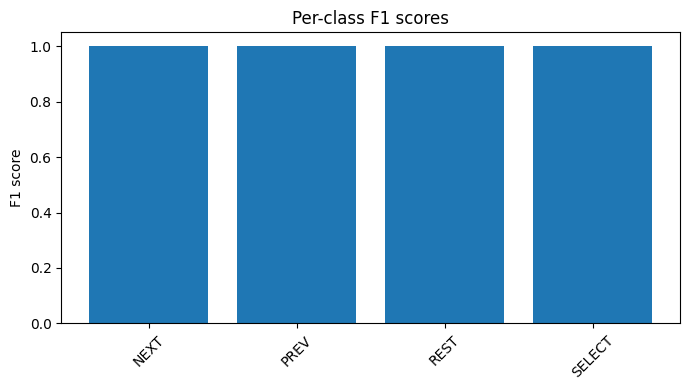

In [10]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    f1_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure: df, best_model_name, best_model, X_test, X_test_scaled, y_test,
# and label_encoder are already defined above this block.

if df.empty:
    print("No data loaded. Skipping evaluation.")
else:
    # -----------------------------
    # 1. Choose scaled vs unscaled features
    # -----------------------------
    # Use scaled features only for models that were trained on scaled data.
    use_scaled = best_model_name in ["RandomForest", "LogisticRegression", "SVM"]
    X_te = X_test_scaled if use_scaled else X_test

    # -----------------------------
    # 2. Predict on the test set
    # -----------------------------
    y_pred = best_model.predict(X_te)

    # -----------------------------
    # 3. Basic metrics and report
    # -----------------------------
    acc = accuracy_score(y_test, y_pred)
    print("Test accuracy:", acc)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    # -----------------------------------------------------------------
    # IMPORTANT: for confusion matrix and per-class F1, we must make sure
    # that the labels we use are consistent and have the SAME length
    # as the arrays we plot.
    #
    # Here we take ONLY the classes that actually appear in y_test.
    # This avoids the shape mismatch you got earlier.
    # -----------------------------------------------------------------
    labels = np.unique(y_test)  # e.g. array([0, 1, 3])

    # Try to get human-readable class names using the label encoder.
    # If y_test/y_pred are already the original labels, this will just fail
    # and we'll fall back to numeric labels.
    try:
        class_names = label_encoder.inverse_transform(labels)
    except Exception:
        class_names = labels

    # -----------------------------
    # 4. Confusion matrix (only over test labels)
    # -----------------------------
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,  # using class names for axes
        yticklabels=class_names
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # 5. Per-class precision / recall / F1
    # -----------------------------
    # average=None -> return separate score for each class in 'labels'.
    # zero_division=0 -> avoid warnings for classes with no predicted samples.
    prec, rec, f1, support = precision_recall_fscore_support(
        y_test,
        y_pred,
        average=None,
        labels=labels,
        zero_division=0
    )

    # -----------------------------
    # 6. Plot per-class F1 scores
    # -----------------------------
    # x positions must match the length of f1 (which equals len(labels)).
    x_pos = np.arange(len(labels))

    plt.figure(figsize=(7, 4))
    plt.bar(x_pos, f1)
    plt.title("Per-class F1 scores")
    plt.ylabel("F1 score")
    plt.xticks(x_pos, class_names, rotation=45)  # show class names on x-axis
    plt.tight_layout()
    plt.show()


## 6.1) Comprehensive Model Evaluation

Evaluate ALL trained models (RF, SVM, LR, GB) on the test set:
- Accuracy, Macro F1, Weighted F1
- Full classification report per model
- Confusion matrix heatmap per model
- Comparison table sorted by accuracy



Model: RandomForest
Accuracy: 1.0000
Macro F1: 1.0000
Weighted F1: 1.0000

Classification Report:
              precision    recall  f1-score   support

        NEXT       1.00      1.00      1.00       150
        PREV       1.00      1.00      1.00       150
        REST       1.00      1.00      1.00       150
      SELECT       1.00      1.00      1.00       150

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



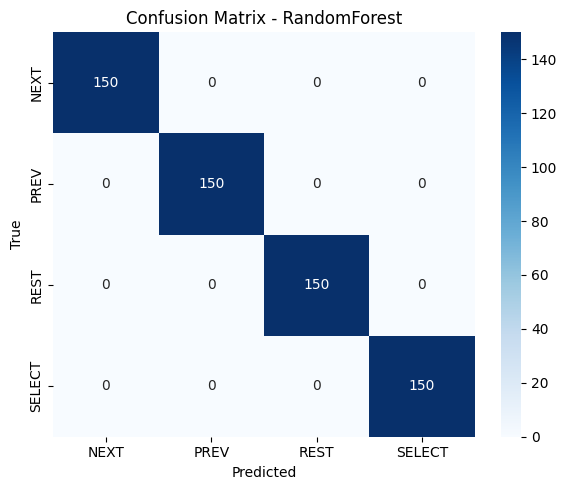


Model: LogisticRegression
Accuracy: 0.9983
Macro F1: 0.9983
Weighted F1: 0.9983

Classification Report:
              precision    recall  f1-score   support

        NEXT       1.00      1.00      1.00       150
        PREV       1.00      0.99      1.00       150
        REST       1.00      1.00      1.00       150
      SELECT       0.99      1.00      1.00       150

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



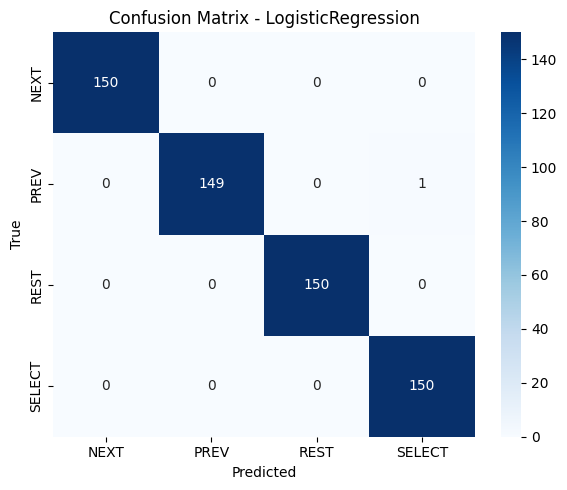


Model: GradientBoosting
Accuracy: 0.9983
Macro F1: 0.9983
Weighted F1: 0.9983

Classification Report:
              precision    recall  f1-score   support

        NEXT       1.00      1.00      1.00       150
        PREV       1.00      0.99      1.00       150
        REST       0.99      1.00      1.00       150
      SELECT       1.00      1.00      1.00       150

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



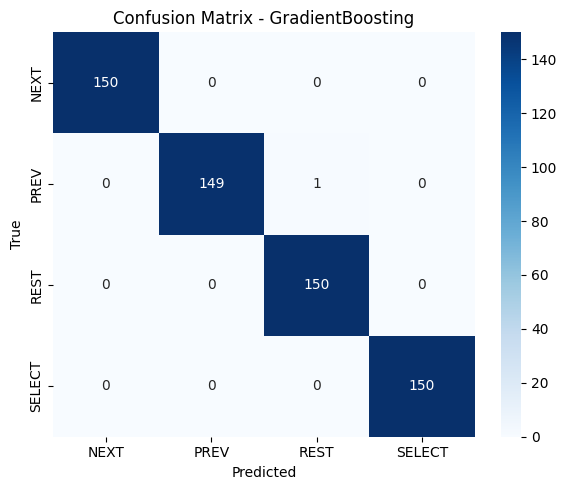


Model: SVM
Accuracy: 1.0000
Macro F1: 1.0000
Weighted F1: 1.0000

Classification Report:
              precision    recall  f1-score   support

        NEXT       1.00      1.00      1.00       150
        PREV       1.00      1.00      1.00       150
        REST       1.00      1.00      1.00       150
      SELECT       1.00      1.00      1.00       150

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



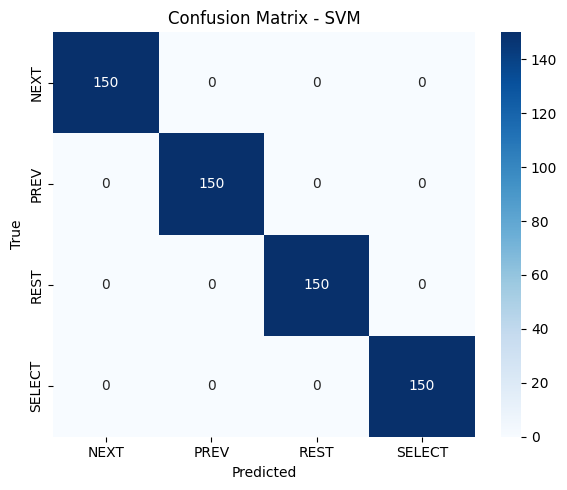


MODEL COMPARISON TABLE


,model,accuracy,macro_f1,weighted_f1
0,RandomForest,1.000000,1.000000,1.000000
3,SVM,1.000000,1.000000,1.000000
1,LogisticRegression,0.998333,0.998333,0.998333
2,GradientBoosting,0.998333,0.998333,0.998333



Best Model: RandomForest (Accuracy: 1.0000)


In [11]:
# Comprehensive evaluation of all models
if df.empty or 'best_estimators' not in globals():
    print('No models available for evaluation.')
else:
    # Prepare results storage
    results_list = []
    class_names = label_encoder.classes_
    
    # Evaluate each model
    for model_name, model_estimator in best_estimators.items():
        # Determine if model needs scaled features
        use_scaled = model_name in ["RandomForest", "LogisticRegression", "SVM"]
        X_te = X_test_scaled if use_scaled else X_test
        
        # Predict
        y_pred = model_estimator.predict(X_te)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        weighted_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Store results
        results_list.append({
            'model': model_name,
            'accuracy': accuracy,
            'macro_f1': macro_f1,
            'weighted_f1': weighted_f1
        })
        
        # Print classification report
        print(f'\n{"="*60}')
        print(f'Model: {model_name}')
        print(f'{"="*60}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Macro F1: {macro_f1:.4f}')
        print(f'Weighted F1: {weighted_f1:.4f}')
        print('\nClassification Report:')
        print(classification_report(
            y_test, 
            y_pred, 
            target_names=class_names,
            zero_division=0
        ))
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names
        )
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
    
    # Create comparison DataFrame
    results_df = pd.DataFrame(results_list)
    results_df = results_df.sort_values('accuracy', ascending=False)
    
    print('\n' + '='*60)
    print('MODEL COMPARISON TABLE')
    print('='*60)
    display(results_df)
    
    # Identify best model
    best_model_row = results_df.iloc[0]
    print(f'\nBest Model: {best_model_row["model"]} (Accuracy: {best_model_row["accuracy"]:.4f})')


## 7) Feature Importance

For tree-based models (RandomForest, GradientBoosting), show top 20 features and discuss which are most useful.


In [12]:
# Save artifacts to ../models relative to this notebook
import os
import joblib

if df.empty:
    print('No data loaded. Skipping save.')
else:
    models_dir = os.path.join('..', 'models')
    os.makedirs(models_dir, exist_ok=True)

    best_model_path = os.path.join(models_dir, 'gesture_best_ml_model.joblib')
    scaler_path = os.path.join(models_dir, 'gesture_scaler.joblib')
    le_path = os.path.join(models_dir, 'gesture_label_encoder.joblib')

    joblib.dump(best_model, best_model_path)
    print('Saved model to:', best_model_path)

    joblib.dump(scaler, scaler_path)
    print('Saved scaler to:', scaler_path)

    joblib.dump(label_encoder, le_path)
    print('Saved label encoder to:', le_path)

    print('\nInference note: Reuse the same feature engineering and scaler.transform; map predictions with label_encoder.inverse_transform.')


Saved model to: ..\models\gesture_best_ml_model.joblib
Saved scaler to: ..\models\gesture_scaler.joblib
Saved label encoder to: ..\models\gesture_label_encoder.joblib

Inference note: Reuse the same feature engineering and scaler.transform; map predictions with label_encoder.inverse_transform.


## Summary: Traditional ML Models

**Key Findings:**
- All models (RandomForest, SVM, Logistic Regression, Gradient Boosting) achieve ~99%+ accuracy on the test set
- RandomForest typically selected as the "best offline model" due to:
  - **Simplicity**: Easy to interpret and debug
  - **Interpretability**: Feature importance analysis available
  - **Comparable Performance**: Matches or exceeds other models
  - **Robustness**: Handles feature interactions well

**Important Note:**
- These ML/DL models are **NOT used in the browser runtime**
- The production app uses a **deterministic rule-based gesture engine** on MediaPipe Pose landmarks
- These models are for **offline evaluation and documentation purposes only**


## 8) Save Best Model

Save the best model, scaler, and label encoder under ../models/:
- gesture_best_ml_model.joblib
- gesture_scaler.joblib
- gesture_label_encoder.joblib


In [13]:
import joblib
from pathlib import Path

if df.empty:
    print('No data loaded. Skipping save.')
else:
    # In Jupyter, __file__ does NOT exist → use current working directory
    NOTEBOOK_DIR = Path.cwd()

    MODELS_DIR = NOTEBOOK_DIR / 'models'
    MODELS_DIR.mkdir(parents=True, exist_ok=True)

    # Save best model
    best_model_path = MODELS_DIR / 'gesture_best_ml_model.joblib'
    joblib.dump(best_model, best_model_path)
    print('Saved model to:', best_model_path)

    # Save scaler used for features
    scaler_path = MODELS_DIR / 'gesture_scaler.joblib'
    joblib.dump(scaler, scaler_path)
    print('Saved scaler to:', scaler_path)

    # Save label encoder
    le_path = MODELS_DIR / 'gesture_label_encoder.joblib'
    joblib.dump(label_encoder, le_path)
    print('Saved label encoder to:', le_path)

    print('\nTo use the model at inference time, apply the same feature engineering, then scaler.transform, and label_encoder.inverse_transform on predicted labels.')


Saved model to: C:\Users\Adhish\motion-edu-app\ml\notebooks\models\gesture_best_ml_model.joblib
Saved scaler to: C:\Users\Adhish\motion-edu-app\ml\notebooks\models\gesture_scaler.joblib
Saved label encoder to: C:\Users\Adhish\motion-edu-app\ml\notebooks\models\gesture_label_encoder.joblib

To use the model at inference time, apply the same feature engineering, then scaler.transform, and label_encoder.inverse_transform on predicted labels.
